# Interpretable Model Start To Finish

I went down a rabbit hole of feature engineering until Hank reminded me that I need a model that is interpretable.  This is a code only walk-through of a model that is a simpler and interpretable model.  Based off my initial model in previous notebooks, therefore all of the cleaning and exploration is the same.

### Contents:
- [Setup & Train/Test/Split](#Setup-&-Train/Test/Split)
- [Data Transformations](#Data-Transformations)
- [Model Fitting!](#Model-Fitting!)
- [R2 and RMSE Values - Linear Regression](#R2-and-RMSE-Values---Linear-Regression)
- [Interpretability](#Interpretability)
- [LINE Assumptions](#LINE-Assumptions)
- [Model Tuning - Regularization](#Model-Tuning---Regularization)

### Setup & Train/Test/Split
---

In [1]:
#Library Imports
import pandas as pd
import numpy as np
import seaborn as sns
import scipy.stats as stats

import matplotlib.pyplot as plt
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.linear_model import LinearRegression, Ridge, RidgeCV, Lasso, LassoCV
from sklearn.metrics import r2_score, mean_squared_error
import statsmodels.api as sm

In [2]:
#Read in relevant csvs
train_clean = pd.read_csv('../datasets/train_clean.csv')
validate_clean = pd.read_csv('../datasets/validate_clean.csv')

In [3]:
#Features in use
features = ['neighborhood',
            'gr_liv_area',
            'overall_qual',]

In [4]:
#Test/Train Data
X = train_clean[features]
y = train_clean['saleprice']

#Validate Data
val = validate_clean[features]

#Train/Test/Split
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 24)

### Data Transformations
___

In [5]:
#Transform the data with ColumnTransformer
ohe = OneHotEncoder(drop = 'first',
                    handle_unknown = 'ignore',
                    sparse_output = False)

ctx = ColumnTransformer(
    transformers =[
        ('one_hot', ohe, ['neighborhood']),
    ], remainder = 'passthrough',
    verbose_feature_names_out = False
)

In [6]:
#Fit and transform the training set
X_train_ctx = pd.DataFrame(ctx.fit_transform(X_train),
                           columns = ctx.get_feature_names_out())

X_test_ctx = pd.DataFrame(ctx.transform(X_test),
                           columns = ctx.get_feature_names_out())


### Model Fitting!
---

In [7]:
#Instantiate Linear Regression Model
lr = LinearRegression()

In [8]:
# Baseline Score
lr.fit(X_train_ctx, y_train)

LinearRegression()

### R2 and RMSE Values - Linear Regression
___

Both the R2  and RMSE values are not as good as my initial model, however this one is interpretable.

In [9]:
print(f'Train R2 value is {round(lr.score(X_train_ctx, y_train),3)}')
print(f'Test R2 value is {round(lr.score(X_test_ctx, y_test),3)}')
print(f'Cross validation cross scores are {cross_val_score(lr, X_test_ctx, y_test)}')

Train R2 value is 0.786
Test R2 value is 0.84
Cross validation cross scores are [0.80950527 0.84484229 0.81361689 0.82682171 0.83034935]


In [10]:
print(f'Root Mean Squared Error of Training Data: {mean_squared_error(lr.predict(X_train_ctx), y_train, squared = False)}')
print(f'Root Mean Squared Error of Test Data: {mean_squared_error(lr.predict(X_test_ctx), y_test, squared = False)}')

Root Mean Squared Error of Training Data: 37092.726573015694
Root Mean Squared Error of Test Data: 30492.455545132947


### Interpretability
---

Below is a table of all features and their coefficient.  For instance, if the house is located in Northridge (neighborhood_NoRidge), then the sale price - **holding all other factors constant** -  will be about  52_910 dollars higher than average.  For every square foot of Living Room space (gr_liv_area) - **again, holding all other factors constant** - , the sale price will increase by about $54.  

In [11]:
interpret_df = pd.DataFrame({'Feature': X_train_ctx.columns, 'Coefficient': lr.coef_})

In [12]:
interpret_df.sort_values(by = 'Coefficient', ascending = False)

,Feature,Coefficient
9,neighborhood_GrnHill,85074.270660
24,neighborhood_StoneBr,74989.156627
18,neighborhood_NridgHt,69306.196543
17,neighborhood_NoRidge,52909.722178
25,neighborhood_Timber,29064.533608
26,neighborhood_Veenker,23678.619891
28,overall_qual,21656.764366
3,neighborhood_ClearCr,19819.301416
23,neighborhood_Somerst,14819.746101
5,neighborhood_Crawfor,12801.679179


In [13]:
lr.intercept_

-31736.07242590183

### LINE Assumptions
___

#### Linearity & Independence
---

In the cleaning and EDA notebook, various plots were created to  show a linear relationship between various features and home price.  To keep this model simple and easily interpretable, only neighborhood, overall quality, and living room area were used. In the interpretability section of this notebook, coefficients of each feature are listed.

I hypothesize that this model is unable to meet the independence assumption.  WHile there aren't any dates listed, I asssume that these houses were sold at different points in time.  Therefore, they cannot meet the assumption of independence.

#### Normality
___

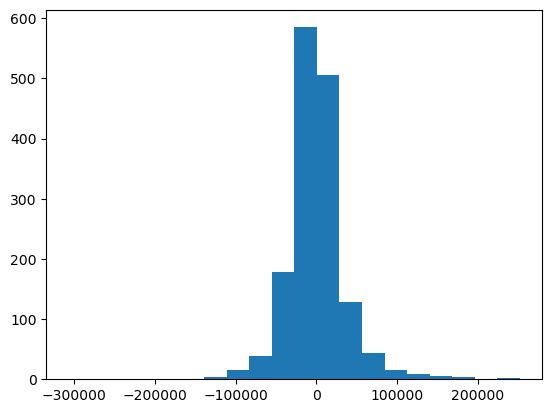

In [14]:
# I was confused about which set of data to use to check LINE assumptions because when
# we talkked about this, it was done on an entire dataset.  We had not covered train/test/split
# yet.  After talking with Alanna in flex time, we agreed it would work best to feed back
# the entire data set into the model for LINE assumptions.
# However, since the data was trained on transformed data, I went back to doing both the 
# train and test sets.  Enouugh data in both sets to see a normal curve if present.

train_preds = lr.predict(X_train_ctx) 
train_resids = y_train - train_preds

plt.hist(train_resids, bins = 20);

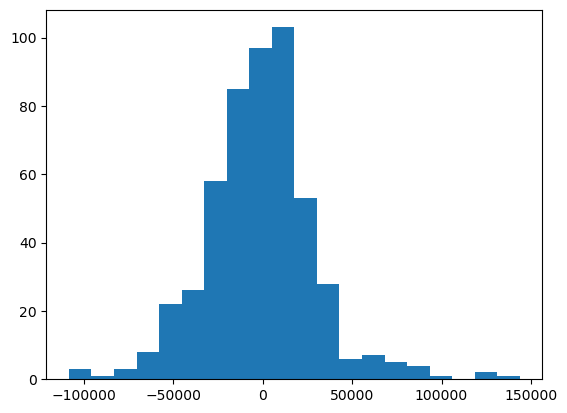

In [15]:
test_preds = lr.predict(X_test_ctx)
test_resids = y_test - test_preds

plt.hist(test_resids, bins = 20);

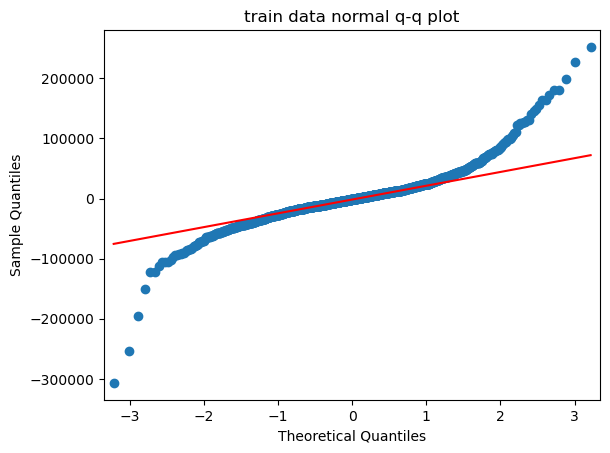

In [16]:
#I thought the QQ Plots Alanna showed us were insightful.
sm.qqplot(train_resids,
         dist= stats.norm,
         line= 'q',)
plt.title('train data normal q-q plot');

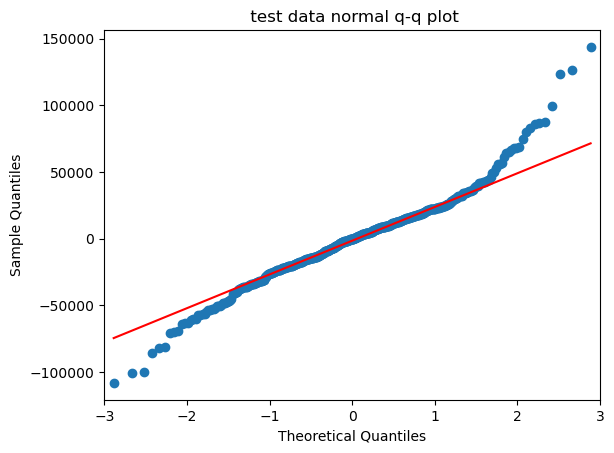

In [17]:
sm.qqplot(test_resids,
         dist= stats.norm,
         line= 'q')
plt.title(' test data normal q-q plot');

Plots show that for the most part, the residuals show a pattern of normality.

#### Equal Variances
___

In [1]:
plt.scatter(train_preds, train_resids)
plt.axhline(0, color = 'xkcd:brick orange')
plt.xlabel('Train Predictions')
plt.ylabel('Train Residuals')
plt.title('Train Predictions vs Residuals');

NameError: name 'plt' is not defined

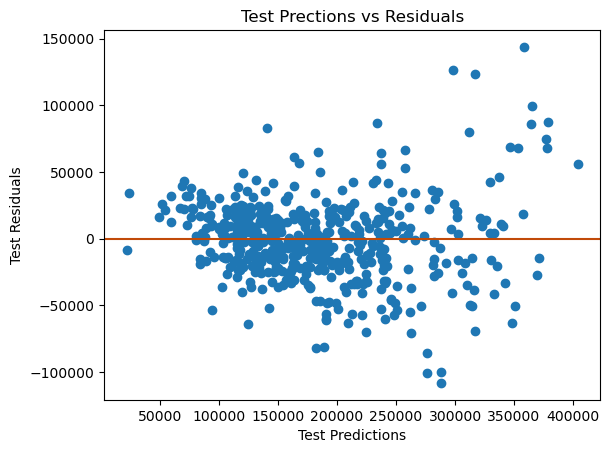

In [19]:
plt.scatter(test_preds, test_resids)
plt.axhline(0, color = 'xkcd:brick orange')
plt.xlabel('Test Predictions')
plt.ylabel('Test Residuals')
plt.title('Test Prections vs Residuals');

There looks to be variance in the middle part of the plot, but it doesn't maintain on the low and a bit of the high end.

### Model Tuning - Regularization
---

#### Ridge Regression

Several iterations using both np.inspace and np.logspace indicatethat the best alpha value to use is ~0.92.  However, the R2 score doesn't change much.  Not using these since the model must be interpretable.

In [20]:
# Setting up a list of ridge alphas to check 
alphas = np.linspace(0.1, 10, 1000)

#Cross validation
ridge_cv = RidgeCV(alphas = alphas, cv = 5)

#Fit using best ridge alpha value
ridge_cv.fit(X_train_ctx, y_train)


RidgeCV(alphas=array([ 0.1       ,  0.10990991,  0.11981982,  0.12972973,  0.13963964,
        0.14954955,  0.15945946,  0.16936937,  0.17927928,  0.18918919,
        0.1990991 ,  0.20900901,  0.21891892,  0.22882883,  0.23873874,
        0.24864865,  0.25855856,  0.26846847,  0.27837838,  0.28828829,
        0.2981982 ,  0.30810811,  0.31801802,  0.32792793,  0.33783784,
        0.34774775,  0.35765766,  0.36756757,  0.37747748,  0.38738739,
        0.39729...
        9.66306306,  9.67297297,  9.68288288,  9.69279279,  9.7027027 ,
        9.71261261,  9.72252252,  9.73243243,  9.74234234,  9.75225225,
        9.76216216,  9.77207207,  9.78198198,  9.79189189,  9.8018018 ,
        9.81171171,  9.82162162,  9.83153153,  9.84144144,  9.85135135,
        9.86126126,  9.87117117,  9.88108108,  9.89099099,  9.9009009 ,
        9.91081081,  9.92072072,  9.93063063,  9.94054054,  9.95045045,
        9.96036036,  9.97027027,  9.98018018,  9.99009009, 10.        ]),
        cv=5)

In [21]:
ridge_cv.alpha_

0.9225225225225226

In [22]:
ridge_cv.best_score_

0.7743213689570891

In [23]:
print(f'Training score with ridge cv: {ridge_cv.score(X_train_ctx, y_train)}')
# Different than .best_score_ because this is using the entire training set, not just a fold from
print(f'Testing score with ridge cv: {ridge_cv.score(X_test_ctx, y_test)}')

Training score with ridge cv: 0.7860604326131654
Testing score with ridge cv: 0.8397416032438019


#### Lasso Regression

After running several iterations of np.linspace and np.logspace, alpha value of ~2.22 is considered the best. Again, not using since the model must be interpretable.

In [24]:
#Lasso alphas to check
l_alphas = np.linspace(1, 3, 1000)

#Cross validation
lasso_cv = LassoCV(alphas = l_alphas)

#Fit model
lasso_cv.fit(X_train_ctx, y_train)

LassoCV(alphas=array([1.        , 1.002002  , 1.004004  , 1.00600601, 1.00800801,
       1.01001001, 1.01201201, 1.01401401, 1.01601602, 1.01801802,
       1.02002002, 1.02202202, 1.02402402, 1.02602603, 1.02802803,
       1.03003003, 1.03203203, 1.03403403, 1.03603604, 1.03803804,
       1.04004004, 1.04204204, 1.04404404, 1.04604605, 1.04804805,
       1.05005005, 1.05205205, 1.05405405, 1.05605606, 1.05805806,
       1.06006006...
       2.93193193, 2.93393393, 2.93593594, 2.93793794, 2.93993994,
       2.94194194, 2.94394394, 2.94594595, 2.94794795, 2.94994995,
       2.95195195, 2.95395395, 2.95595596, 2.95795796, 2.95995996,
       2.96196196, 2.96396396, 2.96596597, 2.96796797, 2.96996997,
       2.97197197, 2.97397397, 2.97597598, 2.97797798, 2.97997998,
       2.98198198, 2.98398398, 2.98598599, 2.98798799, 2.98998999,
       2.99199199, 2.99399399, 2.995996  , 2.997998  , 3.        ]))

In [25]:
lasso_cv.alpha_

2.2272272272272273

In [26]:
print(lasso_cv.score(X_train_ctx, y_train))
print(lasso_cv.score(X_test_ctx, y_test))

0.7863266516684299
0.8396050462830735


In [27]:
lasso_cv.coef_

array([-2.65217630e+04, -4.63171922e+04, -1.93299479e+04,  2.05387917e+04,
        1.03005244e+04,  1.36867638e+04, -1.98430943e+04, -4.73068768e+03,
       -0.00000000e+00,  8.42837232e+04, -3.06282853e+04, -2.76586000e+04,
       -2.48909503e+04,  6.15729134e+03, -5.08866328e+03, -2.82718113e+04,
       -4.65283334e+03,  5.36722255e+04,  7.01220915e+04, -3.35972486e+04,
       -3.35567014e+04, -3.94512830e+03, -6.60005560e+03,  1.56831172e+04,
        7.57271652e+04,  2.98765592e+04,  2.43000840e+04,  5.36884929e+01,
        2.17049053e+04])